# Exploratory Data Analysis

Explore specific attributes about the exports data

In [46]:
from database_settings import spark_utilities

In [81]:
from pyspark.sql.functions import substring, to_date, col, lpad
import matplotlib.pyplot as plt
import math
import numpy as np


In [48]:
# Get the data into a spark dataframe
df = spark_utilities.get_spark_df('peru_exports')

## Historical Data (all batches published)

In [49]:
# Get attributes
print('Number of attributes: ' + str(len(df.columns)))
# Show all possible keys
df.printSchema()

Number of attributes: 47
root
 |-- BATCH_WEEK: string (nullable = true)
 |-- CADU: string (nullable = true)
 |-- CAGE: string (nullable = true)
 |-- CALM: string (nullable = true)
 |-- CEMPTRA: string (nullable = true)
 |-- CENTFIN: string (nullable = true)
 |-- CEST: string (nullable = true)
 |-- CPAIDES: string (nullable = true)
 |-- CPUEDES: string (nullable = true)
 |-- CUNITRA: string (nullable = true)
 |-- CVIATRA: string (nullable = true)
 |-- DCOM: string (nullable = true)
 |-- DDIRCON: double (nullable = true)
 |-- DDIRPRO: string (nullable = true)
 |-- DK: string (nullable = true)
 |-- DK2: string (nullable = true)
 |-- DMAT: string (nullable = true)
 |-- DMER2: string (nullable = true)
 |-- DMER3: string (nullable = true)
 |-- DMER4: string (nullable = true)
 |-- DMER5: string (nullable = true)
 |-- DNOMBRE: string (nullable = true)
 |-- DNOMCON: double (nullable = true)
 |-- DNOMPRO: string (nullable = true)
 |-- FANO: string (nullable = true)
 |-- FANOREG: string (nullable

In [50]:
# Headings to work with:
# 07XXXXXXXX: Hortalizas, plantas, raíces y tubérculos alimenticios
# 08XXXXXXXX: Frutas y frutos comestibles; cortezas de agrios (cítricos), melones o sandías.

hs_to_work = ['07', '08']
filter = r"^("+ "|".join(hs_to_work) + ")" # this way we can do a filter with multiple values

#### PART_NANDI: Headings


In [51]:
headings = df.select('PART_NANDI')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('HS')\
    .toPandas()

In [ ]:
headings['HS'].value_counts()

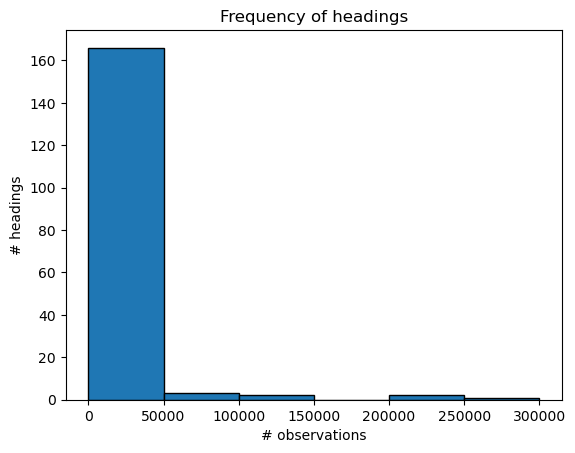

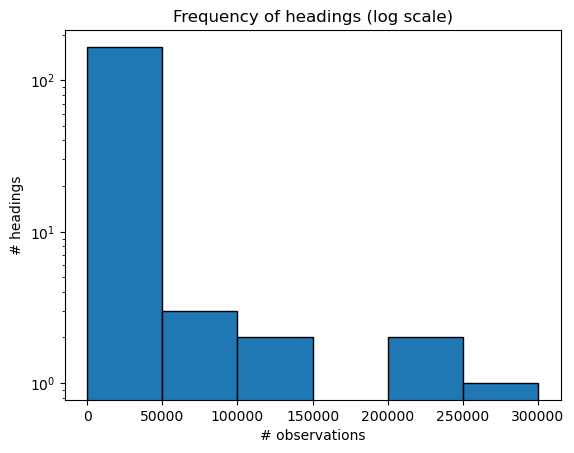

In [53]:
# Plot histogram with the frequency of headings
increments = 50000
bins = range(0, math.ceil(headings['HS'].value_counts().max()) + increments, increments)
plt.hist(headings['HS'].value_counts(), bins=bins, edgecolor='black')
plt.title('Frequency of headings')
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.show()

# Plot histogram in log scale
bins = range(0, math.ceil(headings['HS'].value_counts().max()) + increments, increments)
plt.hist(headings['HS'].value_counts(), bins=bins, edgecolor='black', log=True)
plt.title('Frequency of headings (log scale)')
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.show()

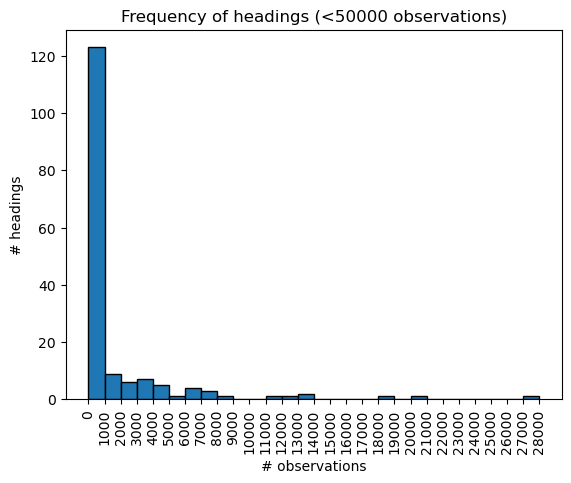

In [54]:
# Plot histogram to see what happens from 0 to 50000 observations
limit = 50000
increments = 1000
filtered_counts = headings['HS'].value_counts()[headings['HS'].value_counts() < limit]
bins = range(0, math.ceil(filtered_counts.max()) + increments, increments)
plt.hist(filtered_counts, bins=bins, edgecolor='black')
plt.title('Frequency of headings (<{} observations)'.format(limit))
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.xticks(bins, rotation='vertical')
plt.show()

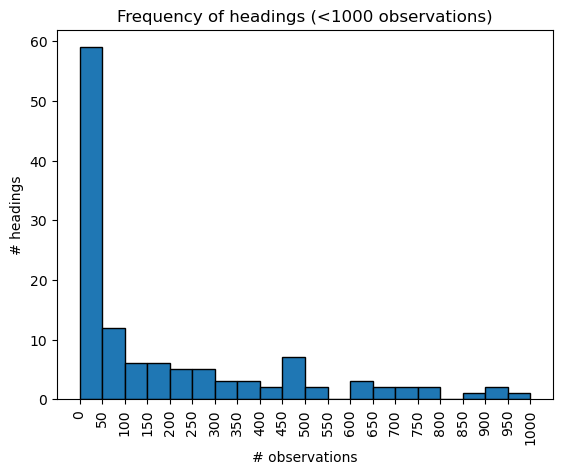

In [55]:
# Plot histogram to see what happens from 0 to 1000 observations
limit = 1000
increments = 50
filtered_counts = headings['HS'].value_counts()[headings['HS'].value_counts() < limit]
bins = range(0, math.ceil(filtered_counts.max()) + increments, increments)
plt.hist(filtered_counts, bins=bins, edgecolor='black')
plt.title('Frequency of headings (<{} observations)'.format(limit))
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.xticks(bins, rotation='vertical')
plt.show()

#### TUNIFIS: Measurement units

In [56]:
# Get all measurement unit types in the data of interest
measurement_units = df.select('PART_NANDI','TUNIFIS')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('TUNIFIS')\
    .toPandas()
measurement_units['TUNIFIS'].value_counts()

KG    1460829
Kg          1
Name: TUNIFIS, dtype: int64

#### QUNIFIS: Amount exported in measurement units


In [57]:
# Get all measurement unit types in the data of interest
amounts_exported = df.select('PART_NANDI','QUNIFIS')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('QUNIFIS')\
    .toPandas()

In [58]:
amounts_exported.sort_values(by='QUNIFIS', ascending=True, inplace=True)
amounts_exported

,QUNIFIS
1222619,0.000
1014533,0.001
855731,0.001
1014534,0.001
1014535,0.001
...,...
1026590,750200.000
732126,750200.000
1340875,847000.000
621939,847000.000


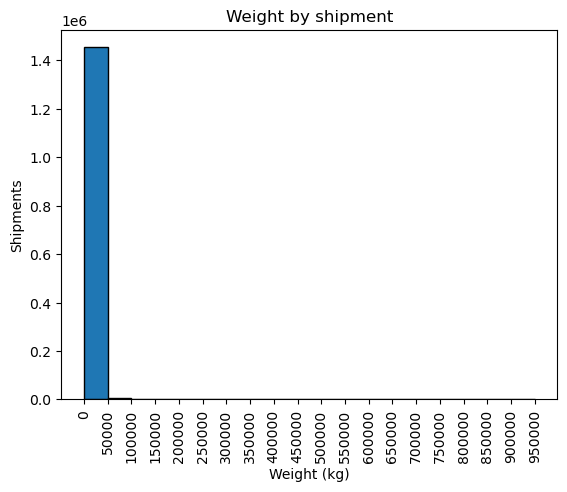

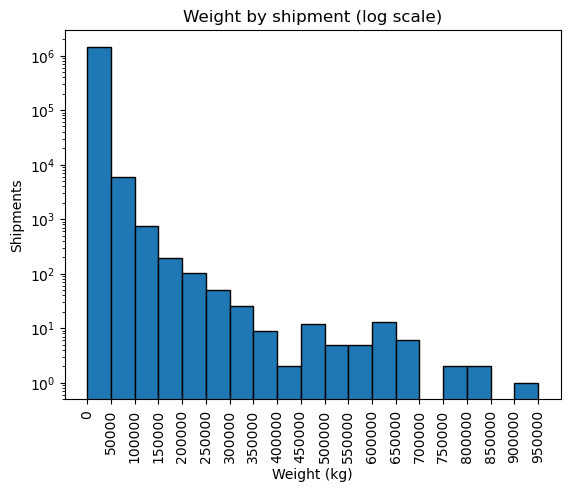

In [59]:
# Plot histogram with the frequency of weights by shipment
increments = 50000
bins = range(0, math.ceil(amounts_exported['QUNIFIS'].max()) + increments, increments)
plt.hist(amounts_exported['QUNIFIS'], bins=bins, edgecolor='black')
plt.title('Weight by shipment')
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

# Plot histogram in log scale
bins = range(0, math.ceil(amounts_exported['QUNIFIS'].max()) + increments, increments)
plt.hist(amounts_exported['QUNIFIS'], bins=bins, edgecolor='black', log=True)
plt.title('Weight by shipment (log scale)')
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.show()

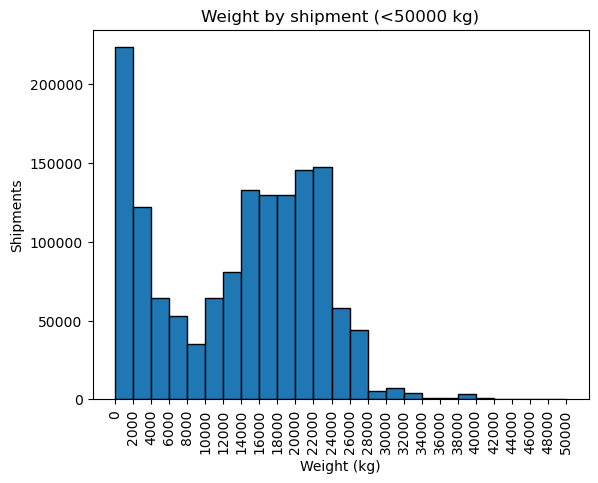

In [60]:
# Plot histogram to see what happens from 0 to 50000 kg
limit = 50000
increments = 2000
filtered = amounts_exported[amounts_exported['QUNIFIS']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

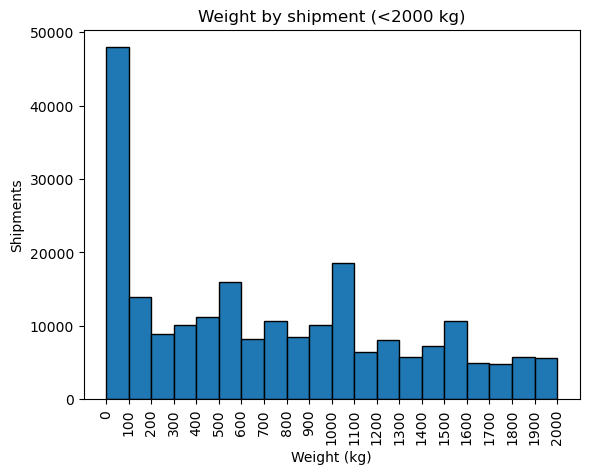

In [61]:
# Plot histogram to see what happens from 0 to 2000 kg
limit = 2000
increments = 100
filtered = amounts_exported[amounts_exported['QUNIFIS']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

#### VPESNET: Net weight of goods


In [62]:
net_weight = df.select('PART_NANDI', 'VPESNET') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('VPESNET') \
    .toPandas()

In [63]:
net_weight.sort_values(by='VPESNET', ascending=True, inplace=True)
net_weight

,VPESNET
1222619,0.000
1014534,0.001
1103906,0.001
1103907,0.001
1298221,0.001
...,...
732126,750200.000
1026590,750200.000
621939,847000.000
1340875,847000.000


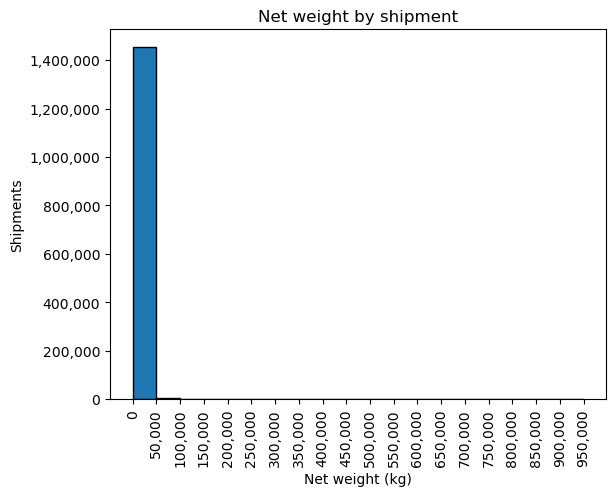

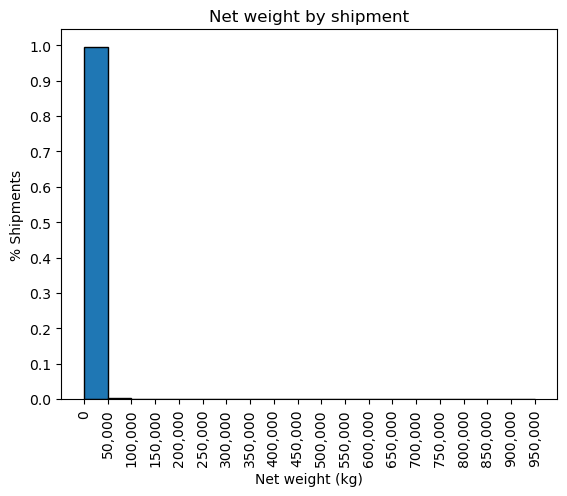

In [95]:
# Plot histogram with the frequency of weights by shipments
increments = 50000
bins = range(0, math.ceil(net_weight['VPESNET'].max()) + increments, increments)
plt.hist(net_weight['VPESNET'], bins=bins, edgecolor='black')
plt.title('Net weight by shipment')
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
increments = 50000
bins = range(0, math.ceil(net_weight['VPESNET'].max()) + increments, increments)
plt.hist(net_weight['VPESNET'], bins=bins, edgecolor='black', weights=np.ones_like(net_weight[net_weight.columns[0]]) / len(net_weight))
plt.title('Net weight by shipment')
plt.xlabel('Net weight (kg)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

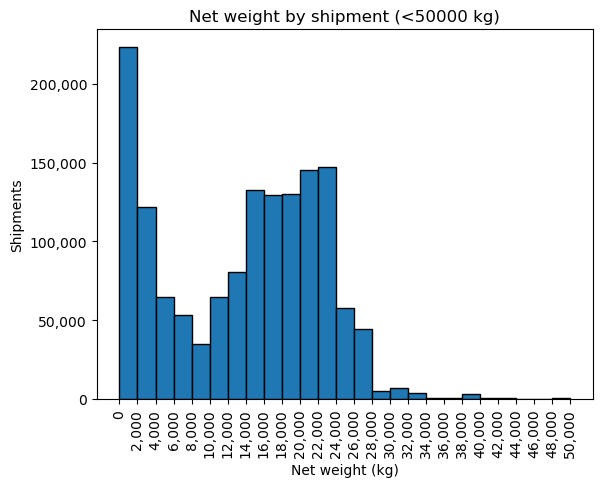

In [65]:
# Plot histogram to see what happens from 0 to 50000 kg
limit = 50000
increments = 2000
filtered = net_weight[net_weight['VPESNET']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Net weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

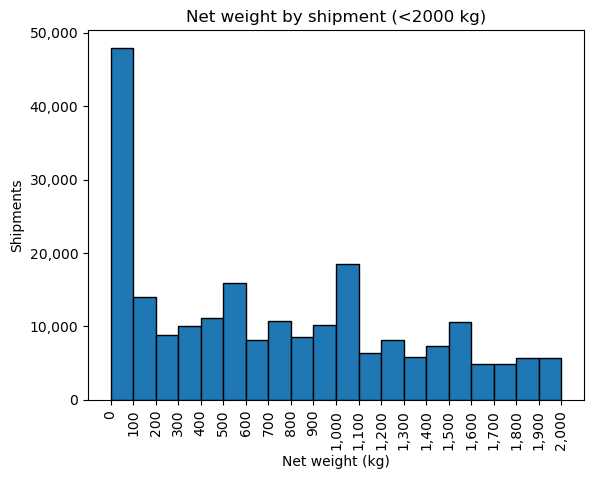

In [66]:
# Plot histogram to see what happens from 0 to 2000 kg
limit = 2000
increments = 100
filtered = net_weight[net_weight['VPESNET']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Net weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

#### VPESBRU: Gross weight of goods


In [67]:
gross_weight = df.select('PART_NANDI', 'VPESBRU') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('VPESBRU') \
    .toPandas()

In [68]:
gross_weight.sort_values(by='VPESBRU', ascending=True, inplace=True)
gross_weight

,VPESBRU
1067177,0.000
1297707,0.001
1298221,0.001
1103906,0.001
1103907,0.001
...,...
1026590,812805.000
916014,917280.000
1340875,917280.000
621939,918420.000


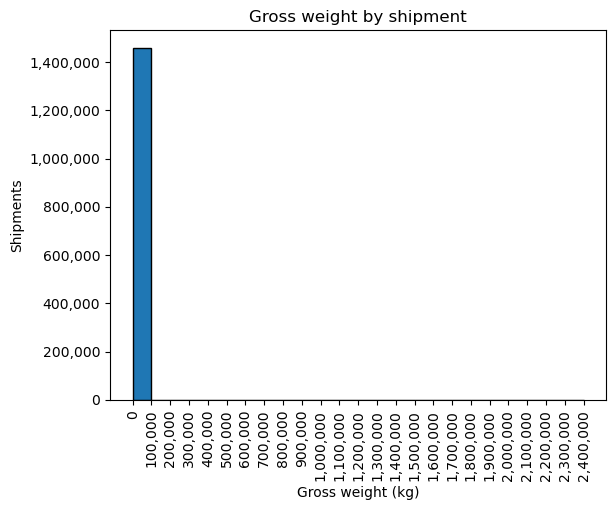

In [69]:
# Plot histogram with the frequency of gross weights by shipments
increments = 100000
bins = range(0, math.ceil(gross_weight['VPESBRU'].max()) + increments, increments)
plt.hist(gross_weight['VPESBRU'], bins=bins, edgecolor='black')
plt.title('Gross weight by shipment')
plt.xlabel('Gross weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

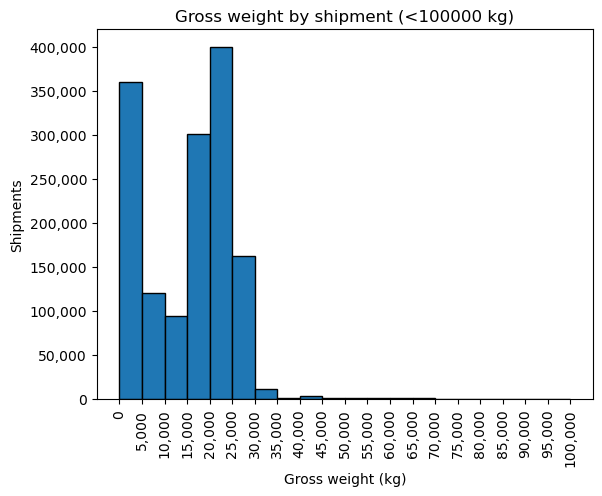

In [72]:
# Plot histogram to see what happens from 0 to 100,000 kg
limit = 100000
increments = 5000
filtered = gross_weight[gross_weight['VPESBRU']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Gross weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Gross weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

#### VFOBSERDOL: Value (USD) of goods at the time of board


In [73]:
value_usd = df.select('PART_NANDI', 'VFOBSERDOL') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('VFOBSERDOL') \
    .toPandas()

In [74]:
value_usd.sort_values(by='VFOBSERDOL', ascending=True, inplace=True)
value_usd

,VFOBSERDOL
855164,0.00
1058528,0.00
725576,0.00
815948,0.00
242279,0.00
...,...
1304037,1642423.35
467446,4552944.00
254348,28260050.00
254347,38260050.00


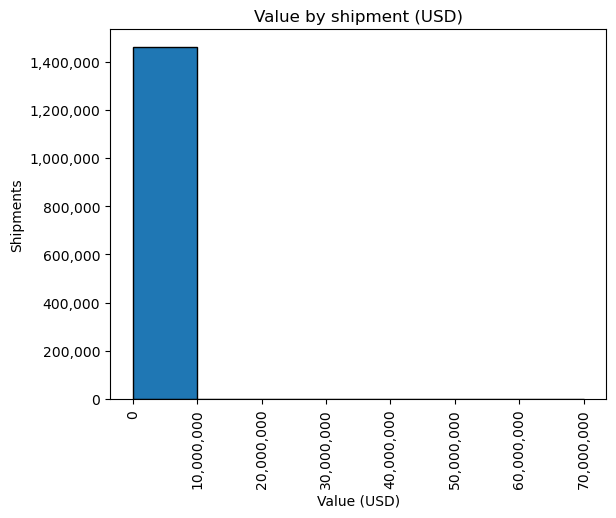

In [100]:
# Plot histogram of value of shipments (USD)
increments = 10000000
bins = range(0, math.ceil(value_usd['VFOBSERDOL'].max()) + increments, increments)
plt.hist(value_usd['VFOBSERDOL'], bins=bins, edgecolor='black')
plt.title('Value by shipment (USD)')
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

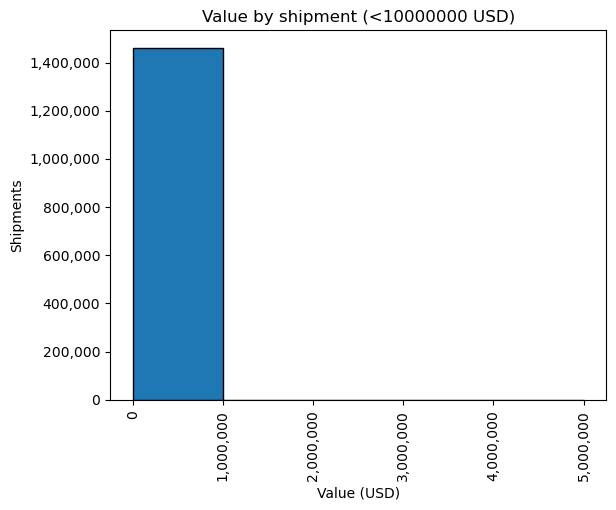

In [102]:
# Plot histogram to see what happens from 0 to 10,000,000 USD
limit = 10000000
increments = 1000000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

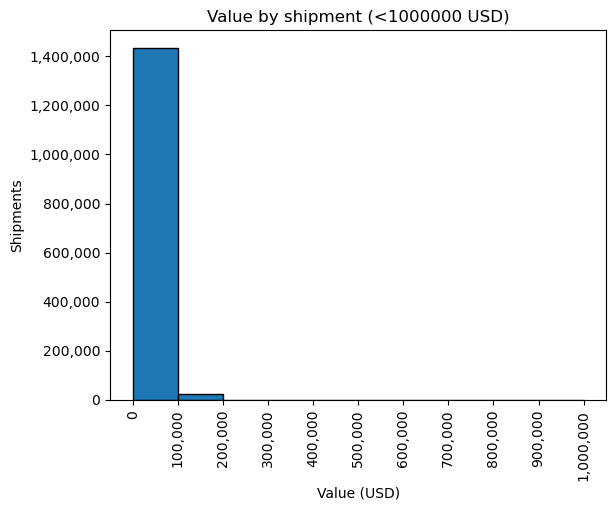

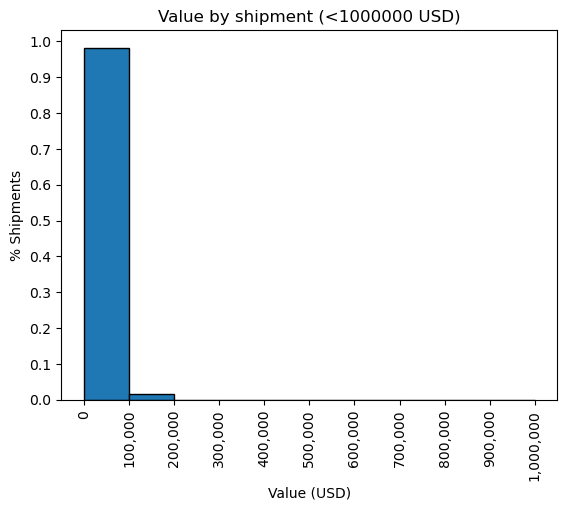

In [116]:
# Plot histogram to see what happens from 0 to 1,000,000 USD
limit = 1000000
increments = 100000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
filtered = value_usd[value_usd['VFOBSERDOL']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black', weights=np.ones_like(filtered[filtered.columns[0]]) / len(value_usd)) # the percentages shown are with respect to all the obsevations, not only to the subset
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

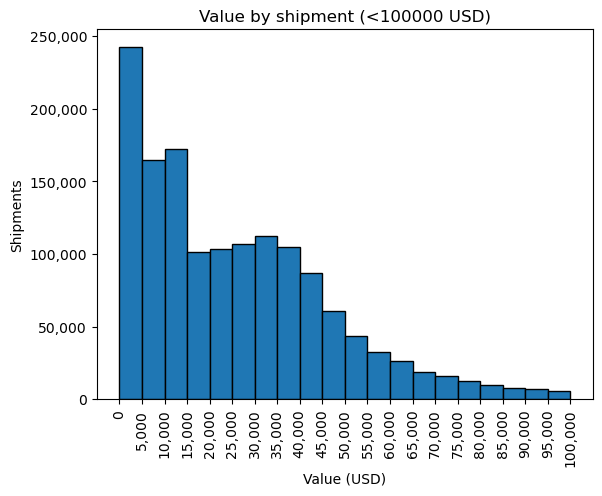

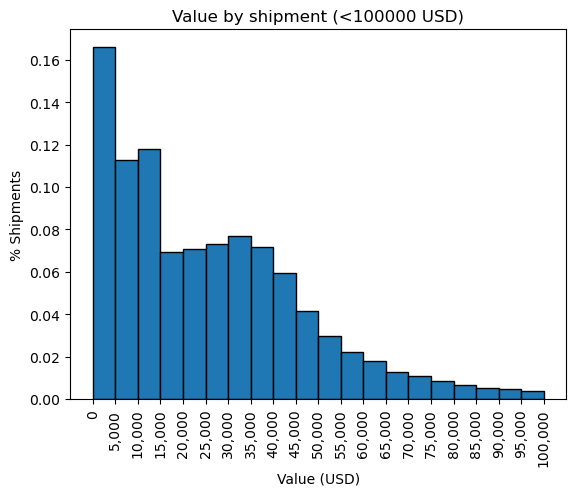

In [114]:
# Plot histogram to see what happens from 0 to 100,000 USD
limit = 100000
increments = 5000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
filtered = value_usd[value_usd['VFOBSERDOL']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black', weights=np.ones_like(filtered[filtered.columns[0]]) / len(value_usd)) # the percentages shown are with respect to all the obsevations, not only to the subset
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

#### CPAIDES: Destination country code


In [117]:
destination = df.select('PART_NANDI', 'CPAIDES') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('CPAIDES') \
    .toPandas()

In [128]:
destination['CPAIDES'].value_counts()

US    530825
NL    283742
ES    120513
GB     96791
CL     64611
       ...  
LA         1
IS         1
BQ         1
GY         1
TK         1
Name: CPAIDES, Length: 128, dtype: int64

#### NDOC, DNOMBRE: Exporter's document number and name


In [155]:
exporter = df.select('PART_NANDI', 'NDOC', 'DNOMBRE') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('NDOC', 'DNOMBRE') \
    .orderBy(col("NDOC"),col("DNOMBRE"))\
    .toPandas()

In [158]:
# Show any rows with empty values in any column
exporter[exporter.isnull().any(axis=1)]

,NDOC,DNOMBRE


In [182]:
# See if there are exporter's document numbers associated with more than one exporter's name
print('Documents for which entity resolution is needed: '+str((exporter.drop_duplicates()['NDOC'].value_counts() > 1).sum())+' of '+str(len(exporter.drop_duplicates()['NDOC'].value_counts())))
exporter.drop_duplicates()['NDOC'].value_counts()

Documents for which entity resolution is needed: 167 of 2638


20484328162    3
20609618354    3
20522308880    2
20606844159    2
20606846941    2
              ..
20535674010    1
20535821098    1
20535884502    1
20535945650    1
No Disponib    1
Name: NDOC, Length: 2638, dtype: int64

In [196]:
# Check quantity of anonymous shipments
print('Anonymous shipments: {} of {} ({}%)'.format(
    str(len(exporter[exporter['NDOC']=='No Disponib'])),
    str(len(exporter)),
    str(round(len(exporter[exporter['NDOC']=='No Disponib'])/len(exporter),3))))

Anonymous shipments: 9799 of 1460830 (0.007%)
